In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

from captum.attr import IntegratedGradients, Saliency
from transformers import ViTForImageClassification, ViTImageProcessor



Загрузим предобученную модель

In [2]:
device = torch.device('cuda')
model_name_or_path = '../saved_model'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path=model_name_or_path,
    num_labels=2,
    attn_implementation="eager",
    output_attentions=True
).to(device)
model.eval()

def denormalize_vit(image_tensor: torch.Tensor) -> torch.Tensor:
    """
    Выполняет обратное преобразование для изображения,
    обработанного с помощью ViTImageProcessor с параметрами:
        - do_rescale=True, rescale_factor=0.00392156862745098
        - do_normalize=True, image_mean=[0.5, 0.5, 0.5], image_std=[0.5, 0.5, 0.5]
    
    Параметры:
      image_tensor (torch.Tensor): тензор изображения в формате (C, H, W)
                                    с нормализованными значениями в диапазоне [-1, 1].
    
    Возвращает:
      torch.Tensor: денормализованное изображение с пиксельными значениями от 0 до 255.
    """
    if isinstance(image_tensor, np.ndarray):
        image_tensor = torch.tensor(image_tensor)
    # Обратное преобразование нормализации: (x * std + mean)
    # В нашем случае: image_rescaled = image_tensor * 0.5 + 0.5,
    # что возвращает значения в диапазоне [0, 1]
    image_rescaled = image_tensor * 0.5 + 0.5
    
    # Обратное преобразование рескейла: делим на rescale_factor (то же, что умножить на 255)
    rescale_factor = 1/255
    image_denorm = image_rescaled / rescale_factor
    
    image_denorm = image_denorm.clamp(0, 255).to(torch.uint8)
    
    return image_denorm

In [3]:
import sys
import os

project_root = 'D:\\pythonProjects\\AIRetailVision\\src'
sys.path.append(project_root)

In [4]:
from custom_dataset import CustomDataset
import json

with open('../src/config.json', 'r') as f:
    config = json.load(f)

In [5]:
test_dataset = CustomDataset(
    root_dir=config['testing_data']['path_orig_test'],
    processor=processor
)

adversarial_test_dataset = CustomDataset(
    root_dir=config['testing_data']['path_pgd_test'],
    processor=processor
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1
)

adversarial_test_dataloader = DataLoader(
    dataset=adversarial_test_dataset,
    batch_size=1
)

In [44]:
def show_integrated_gradients_dual(
    model: torch.nn.Module,
    original_dataloader: DataLoader,
    attacked_dataloader: DataLoader,
    count_show: int = 1,
    indices: list = None,  # список индексов примеров для показа; если None — берутся первые count_show примеров
    device: torch.device = torch.device("cuda")
) -> None:
    """
    param: model: обученная модель
    param: original_dataloader: DataLoader с оригинальными изображениями (ключи: 'pixel_values', 'labels')
    param: attacked_dataloader: DataLoader с атакованными изображениями (ключи: 'pixel_values', 'labels')
    param: count_show: сколько примеров показать
    param: indices: список индексов примеров, которые необходимо показать
    param: device: устройство для вычислений (cpu или cuda)
    """
    # Обёртка для работы Captum (возвращает logits)
    def custom_forward(inputs):
        return model(inputs).logits

    ig = IntegratedGradients(custom_forward)
    shown = 0
    model.to(device)
    model.eval()
    orig_max_delta = 0.0
    att_max_delta = 0.0
    # Итерация по парам батчей (оригинальный и атакованный)
    for idx, (batch_orig, batch_att) in enumerate(zip(original_dataloader, attacked_dataloader)):
        # Если заданы конкретные индексы, пропускаем не нужные
        if indices is not None and idx not in indices:
            continue

        # Обработка оригинального изображения
        inputs_orig = batch_orig['pixel_values'].to(device)
        # target_orig = batch_orig['labels'].to(device)
        target_orig = model(inputs_orig).logits.argmax(dim=1)
        inputs_orig = inputs_orig.requires_grad_()
        baseline_orig = torch.zeros_like(inputs_orig)
        baseline_orig = processor(baseline_orig, return_tensors='pt')['pixel_values'].to(device)
        attributions_orig, delta_orig = ig.attribute(
            inputs_orig, baselines=baseline_orig, target=target_orig.item(), return_convergence_delta=True
        )
        orig_max_delta = max(delta_orig, orig_max_delta)
        # Вычисляем свертку по каналам для получения 2D карты
        attr_map_orig = np.sum(np.abs(attributions_orig.squeeze().cpu().detach().numpy()), axis=0)
        img_orig = inputs_orig.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
        prediction_orig = model(inputs_orig).logits.argmax(dim=1).item()
        
        # Обработка атакованного изображения
        inputs_att = batch_att['pixel_values'].to(device)
        # target_att = batch_att['labels'].to(device)
        target_att = model(inputs_att).logits.argmax(dim=1)
        inputs_att = inputs_att.requires_grad_()
        baseline_att = torch.zeros_like(inputs_att)  # "фоном будет черная картинка, все нули"
        baseline_att = processor(baseline_att, return_tensors='pt')['pixel_values'].to(device)
        attributions_att, delta_att = ig.attribute(
            inputs_att, baselines=baseline_att, target=target_att.item(), return_convergence_delta=True
        )
        att_max_delta = max(delta_att, att_max_delta)
        attr_map_att = np.sum(np.abs(attributions_att.squeeze().cpu().detach().numpy()), axis=0)
        img_att = inputs_att.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
        prediction_att = model(inputs_att).logits.argmax(dim=1).item()

        # Визуализация: два ряда, в первом - оригинал, во втором - атака, с оверлеем атрибуций
        plt.figure(figsize=(16, 8))
        
        # Оригинальное изображение с наложением карты атрибуций
        plt.subplot(2, 3, 1)
        plt.title("Оригинал: Изображение с атрибуциями")
        plt.imshow(denormalize_vit(img_orig))
        plt.imshow(attr_map_orig, cmap='jet', alpha=0.5)  # alpha регулирует прозрачность
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.title("Оригинал: Предсказание")
        plt.text(0.5, 0.5, f'Правильный: {target_orig.item()}\nПредсказанный: {prediction_orig}',
                 fontsize=16, ha='center', va='center')
        plt.axis('off')
        
        # Атакованное изображение с наложением карты атрибуций
        plt.subplot(2, 3, 4)
        plt.title("Атака: Изображение с атрибуциями")
        plt.imshow(denormalize_vit(img_att))
        plt.imshow(attr_map_att, cmap='jet', alpha=0.5)
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.title("Атака: Предсказание")
        plt.text(0.5, 0.5, f'Правильный: {target_att.item()}\nПредсказанный: {prediction_att}',
                 fontsize=16, ha='center', va='center')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        shown += 1
        if shown == count_show:
            break
    print(f'Max delta orig: {orig_max_delta}')
    print(f'Max delta att: {att_max_delta}')


In [7]:
import random
count_show = 5
indices = []
for _ in range(count_show):
    indices.append(random.randint(0,len(test_dataloader.dataset)))
print(indices)

[119, 204, 444, 138, 145]


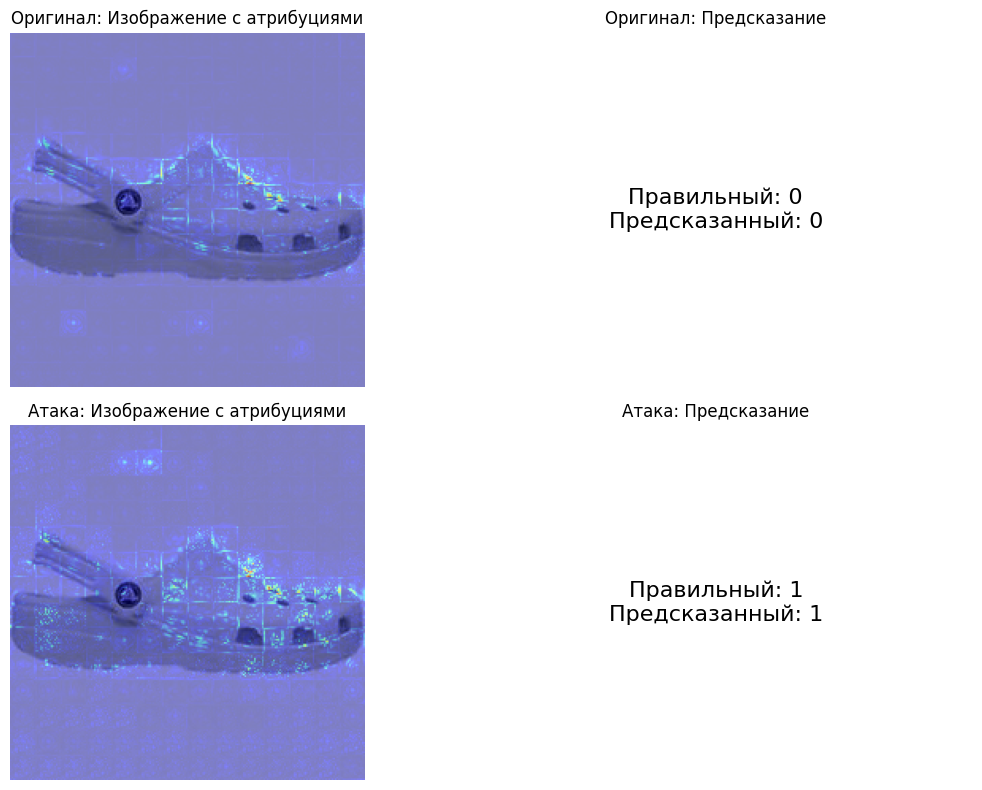

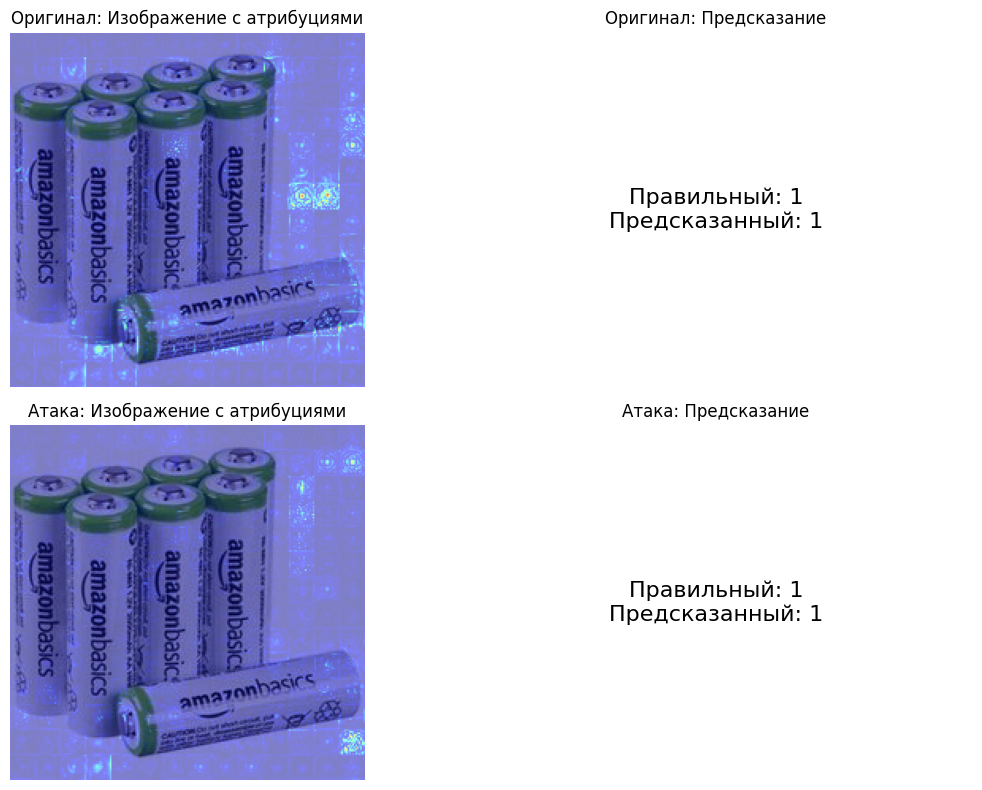

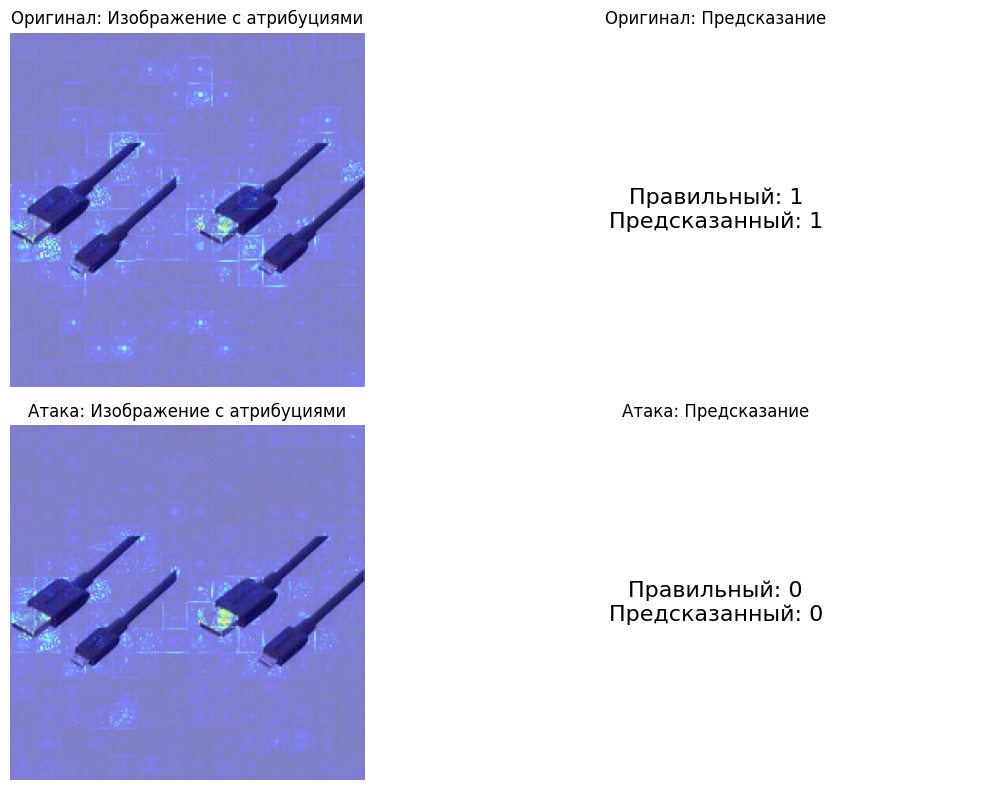

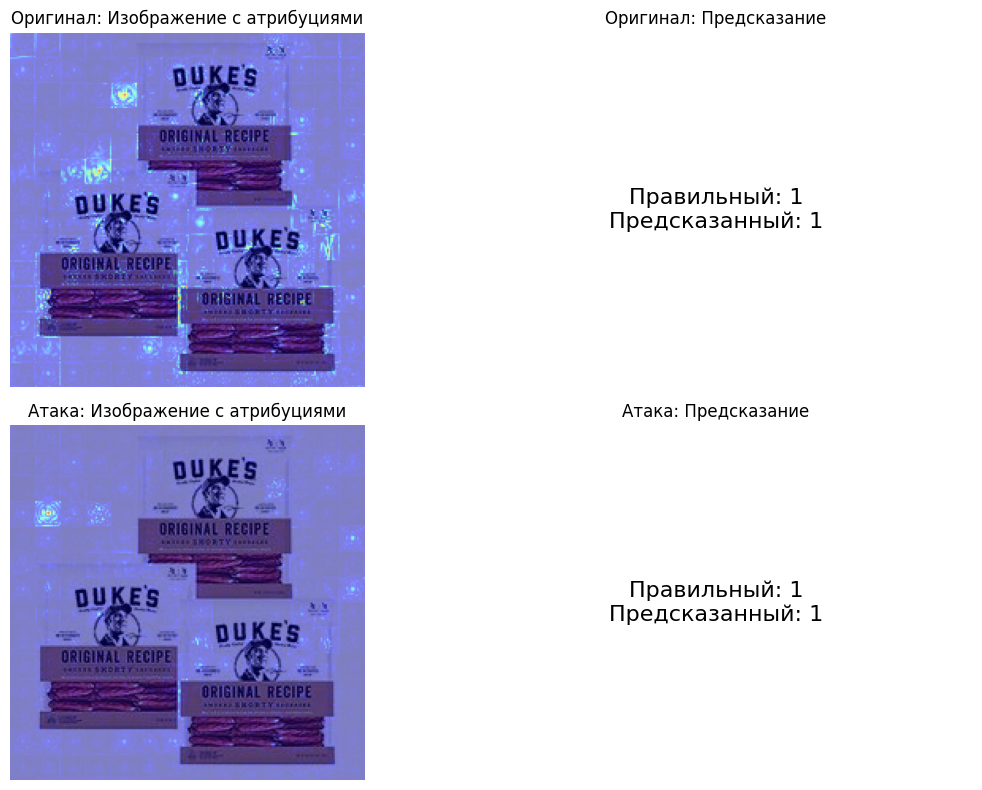

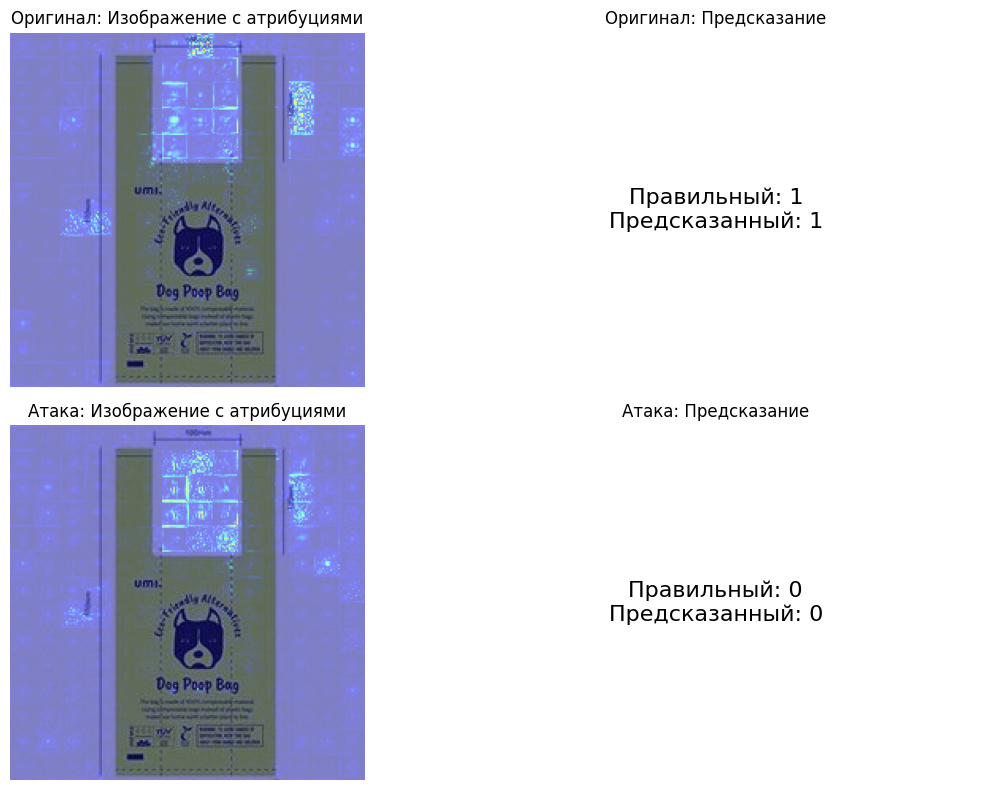

Max delta orig: tensor([1.7035], device='cuda:0')
Max delta att: tensor([0.9485], device='cuda:0')


In [42]:
show_integrated_gradients_dual(
    model=model,
    original_dataloader=test_dataloader,
    attacked_dataloader=adversarial_test_dataloader,
    count_show=count_show,
    indices=indices
)

Глядя на картинки сверху можно заметить очертания объектов, которые им соответствуют (хотя иногда получается месево).
В случае работы с оригинальными изображениями, модель будто фокусируется больше на контурах объектов, либо на самих объектах (к слову не всегда). В случае же атакованных изображений вклад пикселей рассеивается с тех точек, которые были важны в оригинальных изображениях и концентрируется в других местах. Или просто рассеивается. Иногда разницу вообще трудно заметить

Попробуем визуализировать веса слоёв внимания модели.


In [12]:
num_image = indices[0]
print(f'Номер изображения:{num_image}')

Номер изображения:119


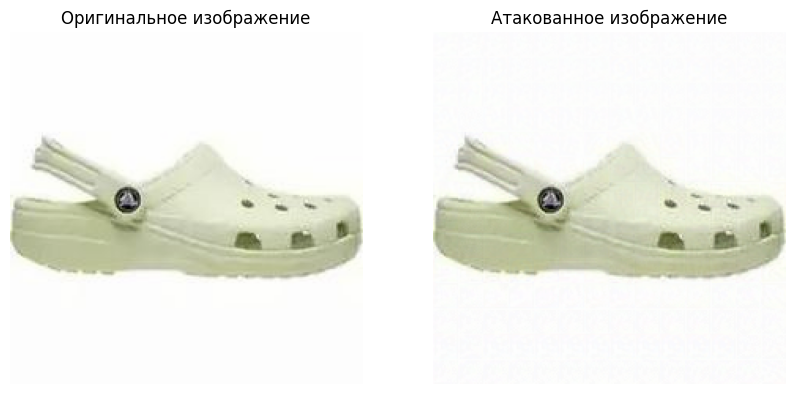

In [13]:
input_orig = test_dataset[num_image]['pixel_values']
input_adv = adversarial_test_dataset[num_image]['pixel_values']
orig_img = input_orig.cpu().detach().numpy().squeeze()
adv_img = input_adv.cpu().detach().numpy().squeeze()

orig_img = orig_img.transpose(1, 2, 0)
adv_img = adv_img.transpose(1, 2, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(denormalize_vit(orig_img))
axes[0].set_title("Оригинальное изображение")
axes[0].axis("off")

axes[1].imshow(denormalize_vit(adv_img))
axes[1].set_title("Атакованное изображение")
axes[1].axis("off")

plt.show()

Оригинал предсказание: 0
Оригинал реальное значение: 0
Атакованное предсказание: 1


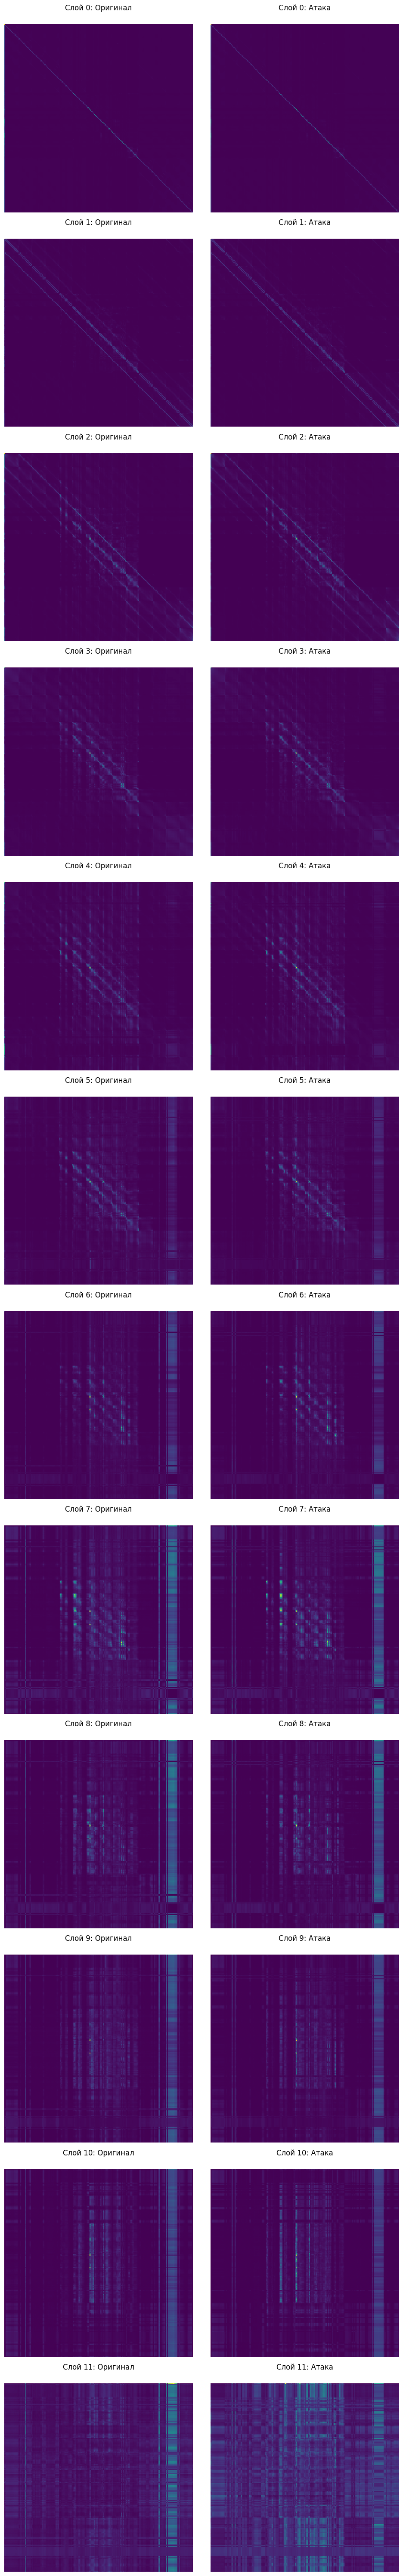

In [14]:
input_orig = test_dataset[num_image]['pixel_values'].to(device)
input_adv = adversarial_test_dataset[num_image]['pixel_values'].to(device)
input_orig.unsqueeze_(0)
input_adv.unsqueeze_(0)
output_orig = model(input_orig)
output_adv = model(input_adv)
print(f'Оригинал предсказание: {output_orig.logits.argmax(dim=1).item()}')
print(f'Оригинал реальное значение: {test_dataset[num_image]['labels']}')
print(f'Атакованное предсказание: {output_adv.logits.argmax(dim=1).item()}')
attentions_orig = output_orig.attentions
attentions_adv = output_adv.attentions
# attn = attentions[1][0]

num_layers = len(attentions_orig)
fig, axes = plt.subplots(num_layers, 2, figsize=(10, 5 * num_layers))

for idx in range(num_layers):
    attn_orig = attentions_orig[idx][0] # берём картинку с номером 0 из батча (в котором всего то 1 картинка)
    attn_adv = attentions_adv[idx][0]
    attn_mean_orig = attn_orig.mean(dim=0).cpu().detach().numpy() # усредним внимание по всем головам в слое (голов 12)
    attn_mean_adv = attn_adv.mean(dim=0).cpu().detach().numpy()

     # Визуализация внимания на обычном изображении (слева)
    ax1 = axes[idx, 0]
    ax1.matshow(attn_mean_orig)
    ax1.set_title(f"Слой {idx}: Оригинал")
    ax1.axis("off")

    # Визуализация внимания на атакованном изображении (справа)
    ax2 = axes[idx, 1]
    ax2.matshow(attn_mean_adv)
    ax2.set_title(f"Слой {idx}: Атака")
    ax2.axis("off")
plt.tight_layout()
plt.show()

Сделаем усреднение по всем слоям

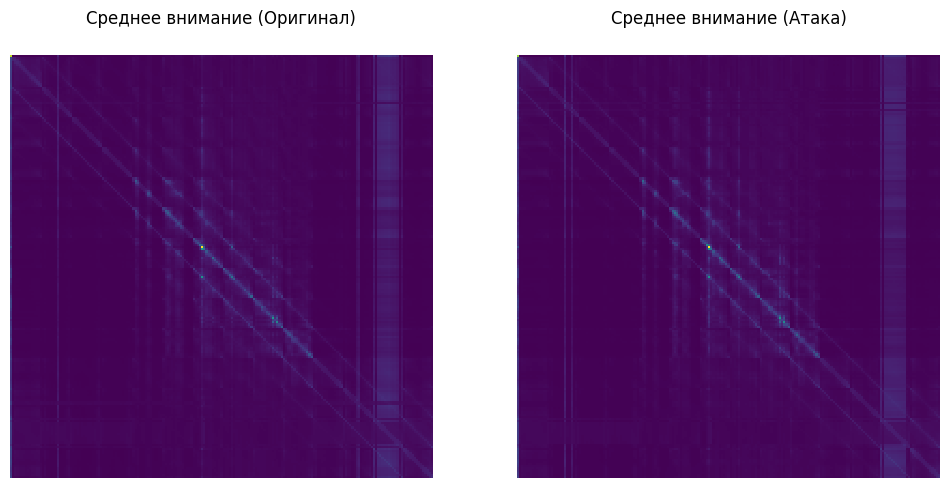

In [15]:
# Усредняем по головам (dim=1) и по слоям (dim=0)
attn_mean_orig = torch.stack(attentions_orig).squeeze(1).mean(dim=1).mean(dim=0).cpu().detach().numpy()
attn_mean_adv = torch.stack(attentions_adv).squeeze(1).mean(dim=1).mean(dim=0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Оригинальное внимание
axes[0].matshow(attn_mean_orig)
axes[0].set_title("Среднее внимание (Оригинал)")
axes[0].axis("off")

# Атакованное внимание
axes[1].matshow(attn_mean_adv)
axes[1].set_title("Среднее внимание (Атака)")
axes[1].axis("off")

plt.show()

Посмотрим разницу

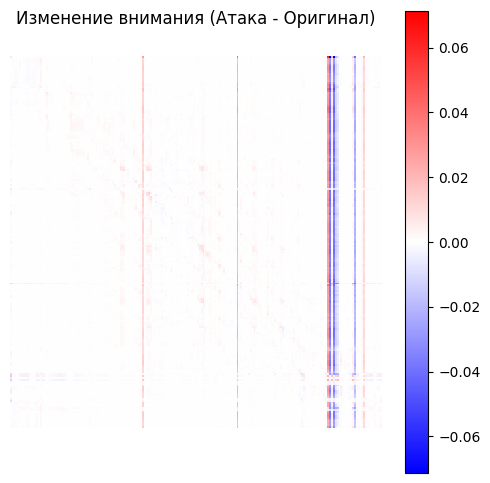

In [81]:
# Разница (Атака - Оригинал)
attn_diff = attn_mean_adv - attn_mean_orig

# Визуализация
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.get_cmap("bwr")  # "bwr" синий-красный
im = ax.matshow(attn_diff, cmap=cmap, vmin=-np.max(np.abs(attn_diff)), vmax=np.max(np.abs(attn_diff)))
plt.colorbar(im)

ax.set_title("Изменение внимания (Атака - Оригинал)")
ax.axis("off")

plt.show()

Синие области - внимание ослабло
Красные области - внимание усилилось

В целом, интерпретация разности вниманий позволяет заметить разницу для атакованных и обычных изображений. Получается, наша атака "попалась". Усреднение по всем головам и всем слоям даёт малую разницу для атакованного и обычного случая, но вот усреднение по головам для каждого конкретного случая может показать бОльшую разницу. И эта разница заметнее на последнем слое внимания.

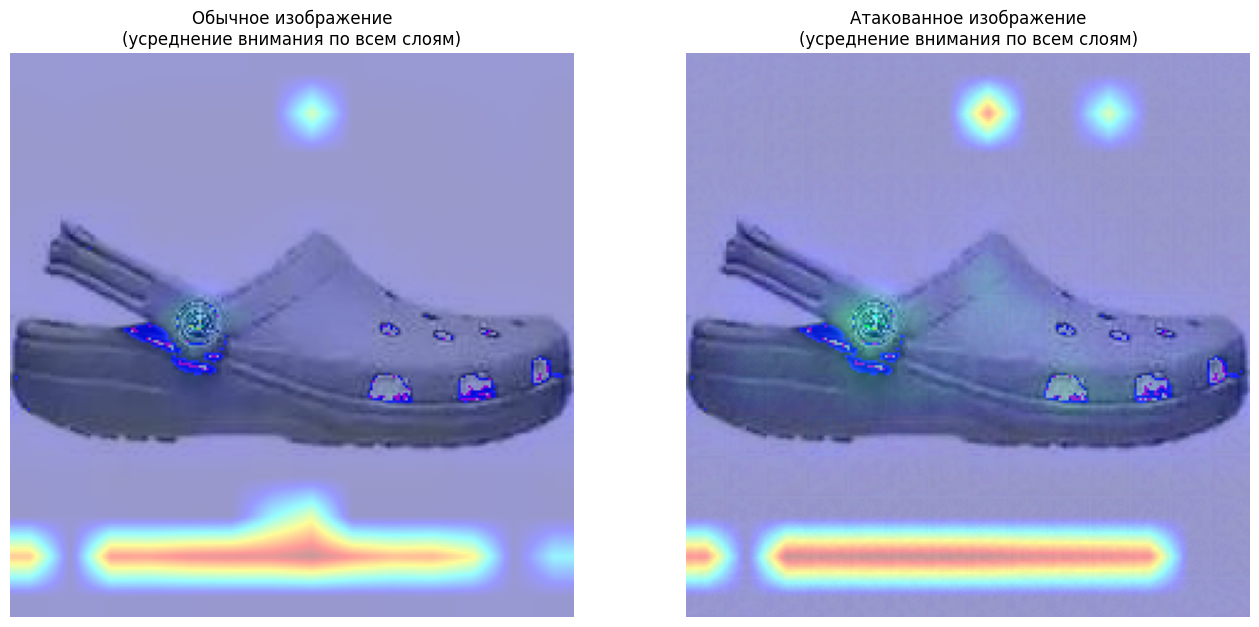

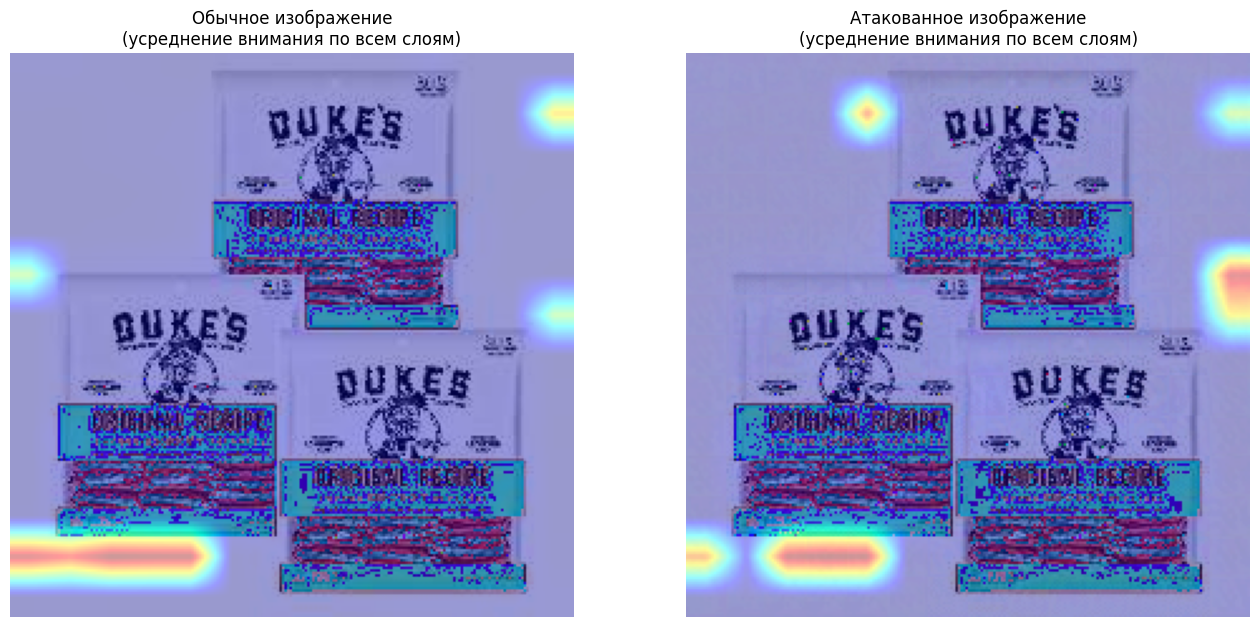

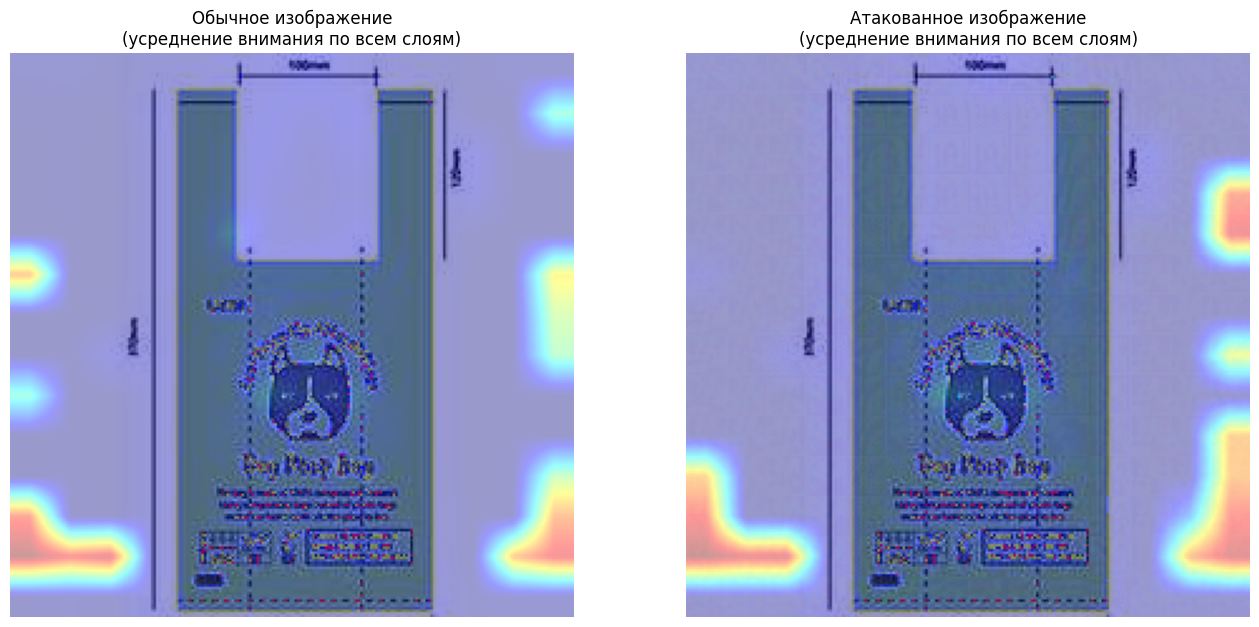

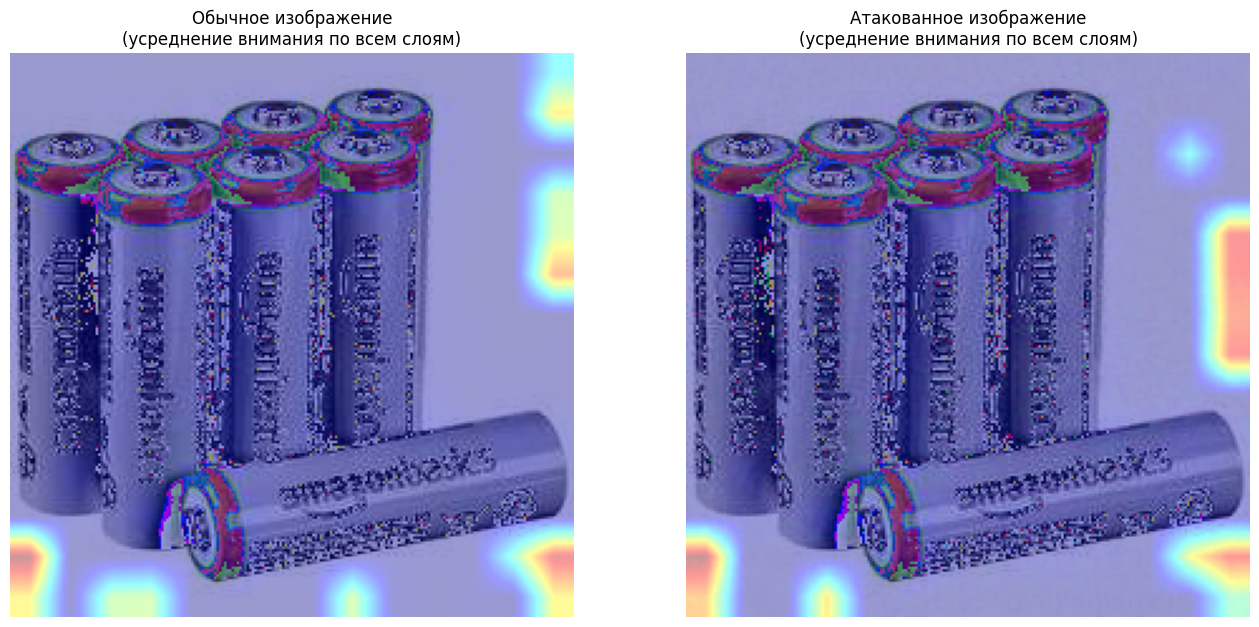

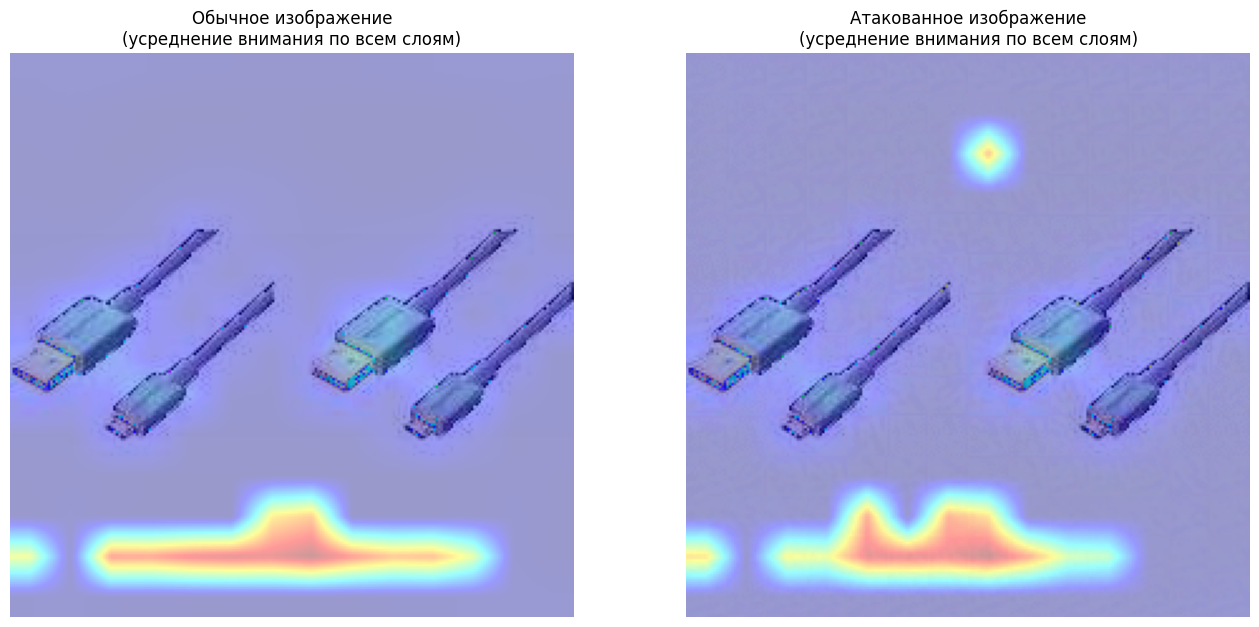

In [17]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.transforms import ToPILImage

def visualize_attention(num_image):
    """
    Функция получает номер изображения, извлекает изображения, сообветствующие номеру из датасета с атакованными
    и обычными картинками, затем извлекает веса слоёв внимания, визуализирует их и накладывает поверх изображения
    """
    global test_dataset, adversarial_test_dataset, model, device

    # Получение тензоров из датасетов
    image_tensor = test_dataset[num_image]['pixel_values']
    adv_image_tensor = adversarial_test_dataset[num_image]['pixel_values']

    to_pil = ToPILImage()
    orig_image = to_pil(image_tensor.cpu())
    adv_image = to_pil(adv_image_tensor.cpu())

    orig_inputs = image_tensor.unsqueeze(0)  # (1, 3, H, W)
    adv_inputs = adv_image_tensor.unsqueeze(0)

    # тут берём веса внимания
    with torch.no_grad():
        orig_outputs = model(orig_inputs.to(device))
        adv_outputs = model(adv_inputs.to(device))
        orig_attentions = orig_outputs.attentions
        adv_attentions = adv_outputs.attentions

    def get_avg_attention(attentions):
        """
        усредняем внимание по головам и по слоям.
        """
        attn_list = [] # массив для усреднённых по головам вниманий каждого слоя
        for layer_attn in attentions:
            layer_attn = layer_attn[0] # берём первый (и единственный) элемент в батче
            cls_attn = layer_attn[:, 0, 1:]  # берём внимание к токенам cls (на 0 позиции) со всех голов, а на 3 позиции, мы наоборот оставляем все остальные токены, кроме cls
            avg_layer_attn = cls_attn.mean(dim=0) # усредняем по головам
            attn_list.append(avg_layer_attn)
        avg_all_layers = torch.stack(attn_list, dim=0).mean(dim=0)  # усредняем по слоям
        return avg_all_layers

    orig_avg_attn = get_avg_attention(orig_attentions)
    adv_avg_attn = get_avg_attention(adv_attentions)
    
    grid_size = int(np.sqrt(orig_avg_attn.shape[0])) # корень из 196 = 14, ну как минимум это ожидается, т.к. модель
                                                    # делит изображение на патчи 16x16
    orig_attn_map = orig_avg_attn.reshape(grid_size, grid_size).cpu().numpy()
    adv_attn_map = adv_avg_attn.reshape(grid_size, grid_size).cpu().numpy()

    # Интерполяция карты внимания до размеров исходного изображения
    width, height = orig_image.size  # (ширина, высота)
    orig_attn_map = cv2.resize(orig_attn_map, (width, height))
    adv_attn_map = cv2.resize(adv_attn_map, (width, height))

    # Нормализация карт внимания в диапазоне [0, 1]
    orig_attn_map = (orig_attn_map - orig_attn_map.min()) / (orig_attn_map.max() - orig_attn_map.min())
    adv_attn_map = (adv_attn_map - adv_attn_map.min()) / (adv_attn_map.max() - adv_attn_map.min())


    # Преобразование в numpy массив для вывода на экран
    image_np = image_tensor.cpu().permute(1, 2, 0).numpy()
    if image_np.max() <= 1.0:
        image_np = (image_np * 255).astype(np.uint8)
    else:
        image_np = image_np.astype(np.uint8)
    
    adv_image_np = adv_image_tensor.cpu().permute(1, 2, 0).numpy()
    if adv_image_np.max() <= 1.0:
        adv_image_np = (adv_image_np * 255).astype(np.uint8)
    else:
        adv_image_np = adv_image_np.astype(np.uint8)

    # Применение тепловой карты для визуализации карты внимания
    orig_heatmap = cv2.applyColorMap(np.uint8(255 * orig_attn_map), cv2.COLORMAP_JET)
    orig_heatmap = cv2.cvtColor(orig_heatmap, cv2.COLOR_BGR2RGB)
    adv_heatmap = cv2.applyColorMap(np.uint8(255 * adv_attn_map), cv2.COLORMAP_JET)
    adv_heatmap = cv2.cvtColor(adv_heatmap, cv2.COLOR_BGR2RGB)

    # Наложение heatmap на изображения с альфа-смешиванием
    alpha = 0.4  # степень прозрачности heatmap
    overlayed_orig = cv2.addWeighted(image_np, 1 - alpha, orig_heatmap, alpha, 0)
    overlayed_adv = cv2.addWeighted(adv_image_np, 1 - alpha, adv_heatmap, alpha, 0)

    # Отображение результатов рядом
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(overlayed_orig)
    axs[0].axis("off")
    axs[0].set_title("Обычное изображение\n(усреднение внимания по всем слоям)")
    axs[1].imshow(overlayed_adv)
    axs[1].axis("off")
    axs[1].set_title("Атакованное изображение\n(усреднение внимания по всем слоям)")
    plt.show()


for idx in indices:
    visualize_attention(num_image=idx)


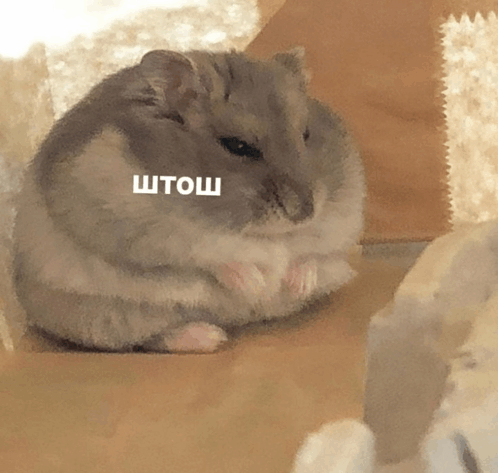

Либо я что-то делаю не так, либо PGD атака не очень попадается на этом способе интерпретации

Небольшой итог всего, что можно видеть выше. Integrated Gradients слабо меняется при атаке PGD, возможно из-за того, что возмущения достаточно малы. При визуализации усреднения по головам для каждого слоя, на некоторых слоях можно хорошо рассмотреть разницу между атакованными и обычными примерами. Но вот если усреднять по всем слоям и накладывать на изображение, тол визуальное различие часто довольно мало. Иногда на тепловой карте при атаке появляется 1-2 точки, куда раньше модель не обращала особого внимания или внимание усиливается в тех областях, где оно было.